# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [17]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#read the data
url = "recipe_site_traffic_2212.csv"
df = pd.read_csv(url)
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Validation and Cleaning
## Summary:
The first step is to understand the structure of the data and identify any issues. Let's start by checking the dimensions, data types, and missing values. <br>
In printing the first few rows, we can see that there are 8 columns: recipe, calories, carbohydrate, sugar, protein, category, servings, and high_traffic. <br>
We can also see that there are missing values in some columns. <br>
Since high_traffic column only keeps track of "High" and Nan values, we treat NaN values as those that are not high traffic.

The data type of the columns should be:
- recipe: object or int64 (this is already a unique identifier) 
- calories, carbohydrate, sugar, protein, servings: float64
- category: object (string category)
- high_traffic: boolean

Step for cleaning and validating the columns:
- drop the recipe column because it's a unique identifier and not relevant for the analysis.
- Check for Inconsistencies in the numerical columns. Cleaned the servings column by removing the string characters and converting it to float64.
- handle missing values in the calories, carbohydrate, sugar, protein, and servings columns. Check the skewness to decide on an appropriate method (imputation using median).
- convert high_traffic to a numerical column (True -> 1, False -> 0)
- Check for any inconsistencies in the category column (e.g., lowercase or uppercase).

Removing data:
- There is no need to drop data in this case since we will try to make a model that only focuses between category and high_traffic.

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


In [19]:
#check number of unique values
df.nunique()

# we can see that recipe has 947 values, indicating that there are no duplicate recipes.

recipe          947
calories        891
carbohydrate    835
sugar           666
protein         772
category         11
servings          6
high_traffic      1
dtype: int64

In [20]:
# However, we can see that there are duplicates in the other columns. Note that the "recipe" column is the name of the recipe and cannot be duplicated. The process in the cooking might be different, having different recipe number for the same recipe.
df.drop("recipe",axis=1).duplicated().sum()

23

In [21]:
# checking servings
print(df.servings.value_counts())
print("Let's clean the servings column by removing the strings and converting them to numbers.")
print("Here, we can just use subsetting the first character to check if it's a digit, and if so, convert it to a number.")
df['servings'] = df['servings'].str.extract(r'(\d+)').astype(int)
df.servings.value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64
Let's clean the servings column by removing the strings and converting them to numbers.
Here, we can just use subsetting the first character to check if it's a digit, and if so, convert it to a number.


4    391
6    198
2    183
1    175
Name: servings, dtype: int64

# Exploratory Analysis
In order to clean the data, we need to check the distribution of the variables, look for outliers, and identify any patterns. This will help us identify what statistical measures to use and whether any preprocessing is needed.

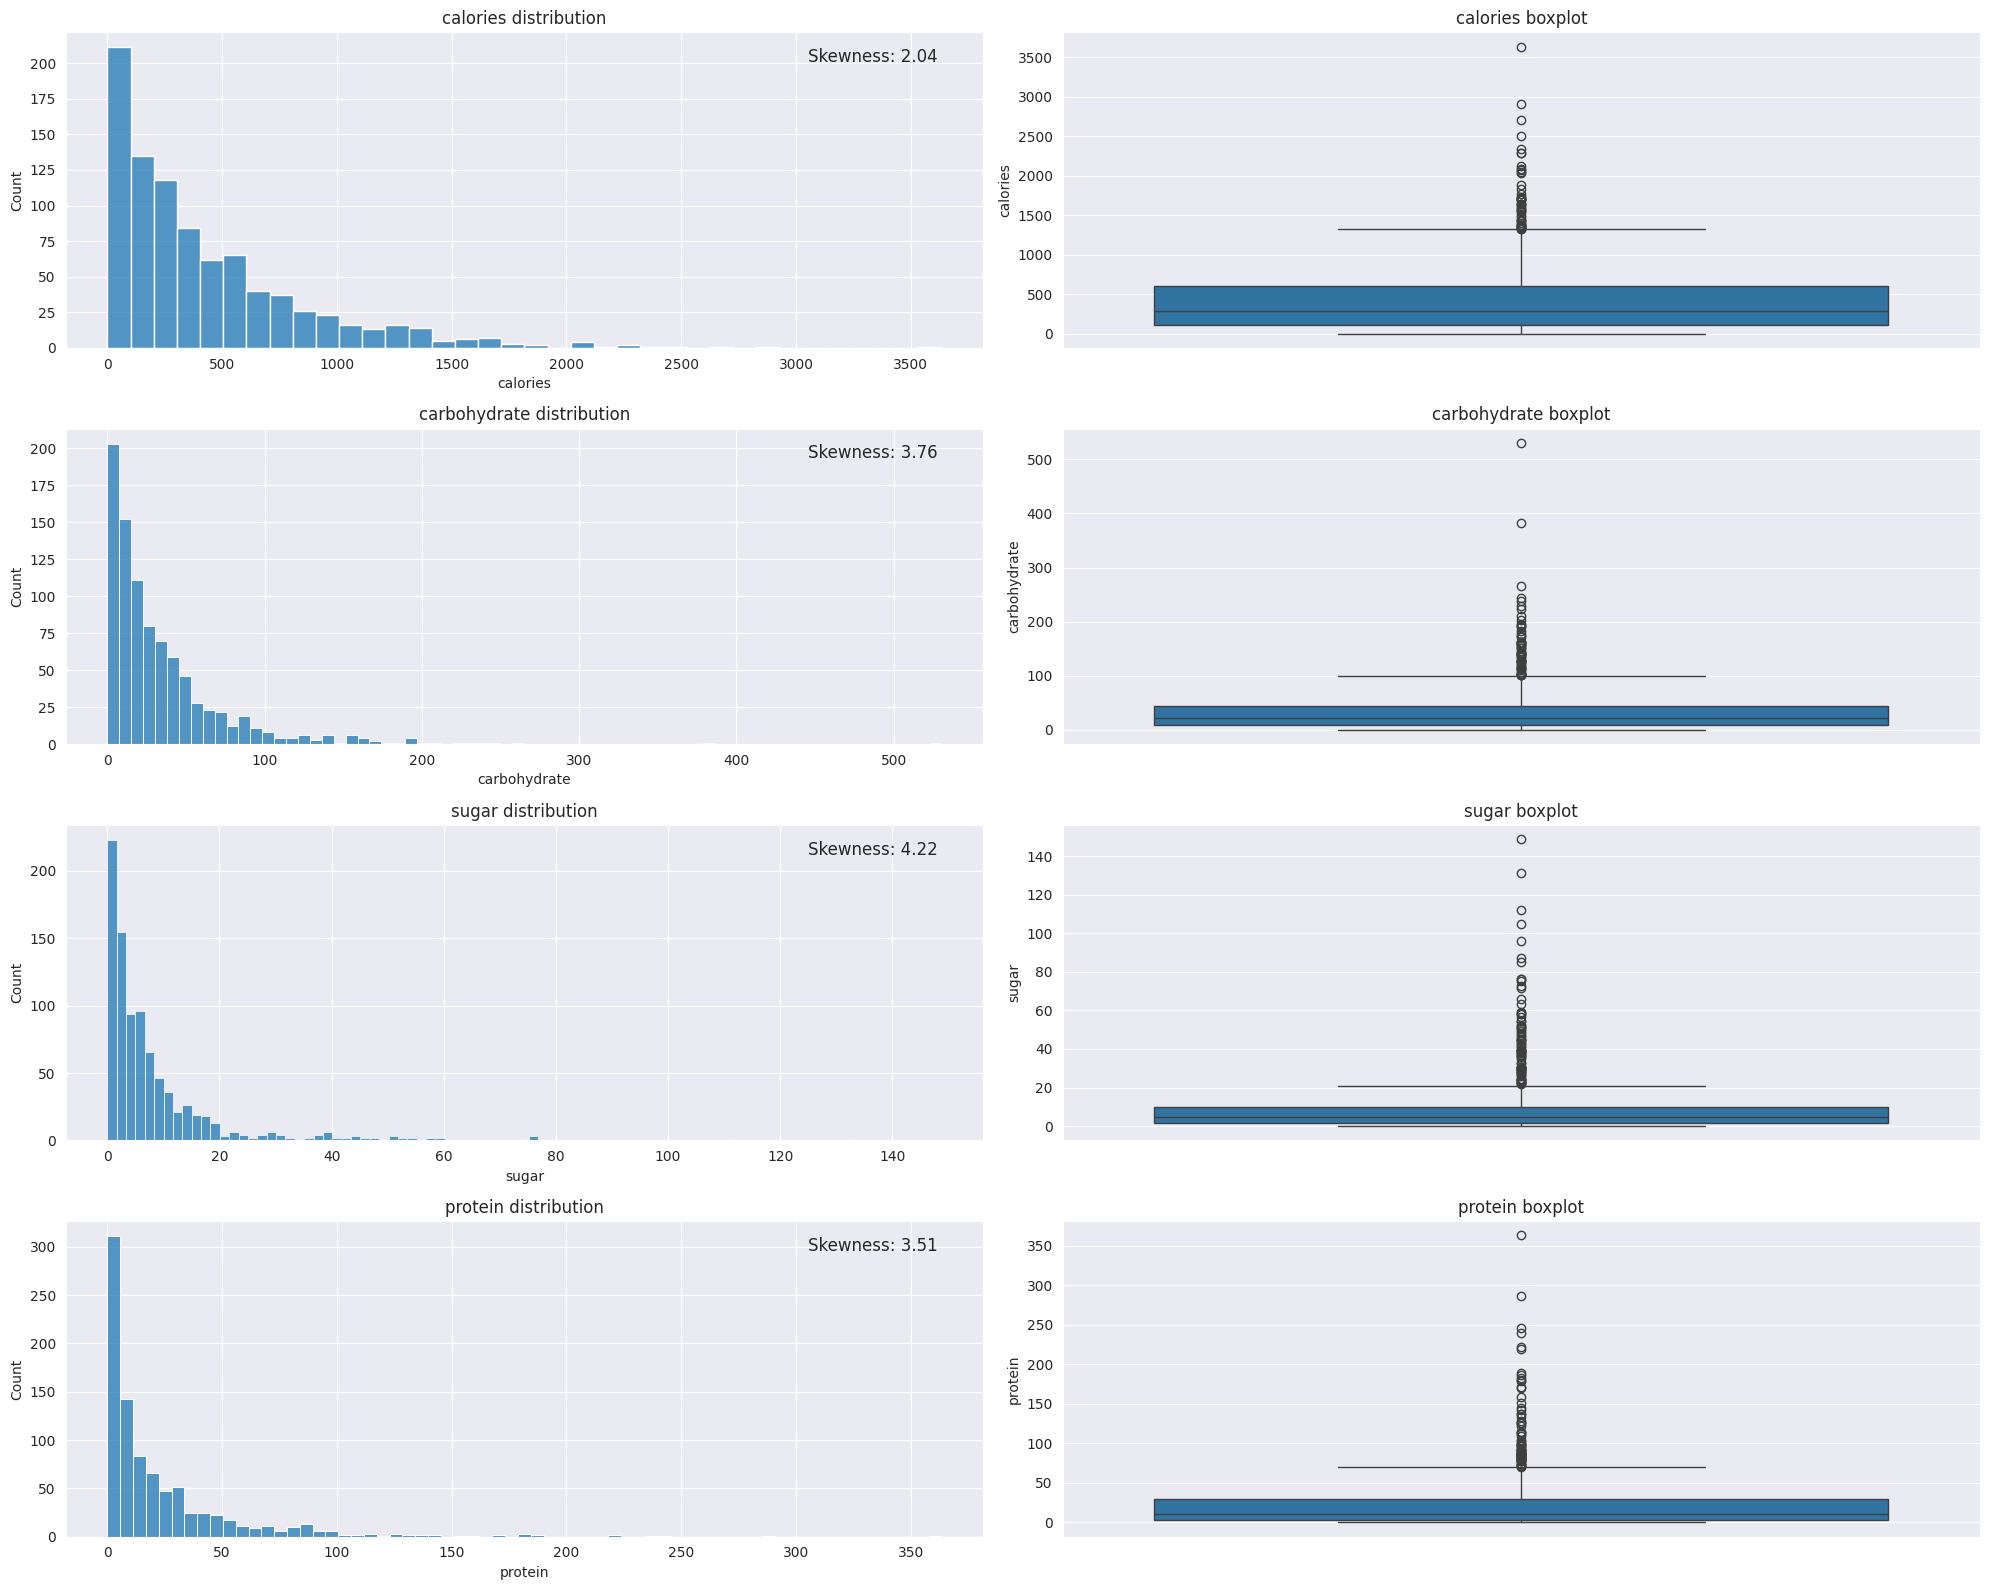

In [22]:
def plot_continuous_variables(df, variables):
    fig, ax = plt.subplots(len(variables), 2, figsize=(20, 4 * len(variables)))
    for i, var in enumerate(variables):
        sns.histplot(df[var], ax=ax[i, 0])
        ax[i, 0].set_title(f'{var} distribution')
        sns.boxplot(df[var], ax=ax[i, 1])
        ax[i, 1].set_title(f'{var} boxplot')
        # annotate skewness
        skewness = df[var].skew()
        ax[i, 0].text(0.95, 0.95, f'Skewness: {skewness:.2f}', transform=ax[i, 0].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=12)
    plt.tight_layout()
    plt.show()

# plot continuous variables
continuous_variables = ['calories', 'carbohydrate', 'sugar', 'protein']
plot_continuous_variables(df, continuous_variables)

In [23]:
#for row in df.iterrows():
#    # check if there are rows that have 3 or 4 NAN values
#    if pd.isna(row[1].calories) or pd.isna(row[1].carbohydrate) or pd.isna(row[1].sugar) or pd.isna(row[1].protein):
#        df.drop(index=row[0], inplace=True)

#print(f'Remaining rows: {len(df)}')

## Skewness of the continuous variables
We can see that "calories", "carbohydrate", "sugar", and "protein" columns are right skewed. We can use median imputation for the missing values. <br>
For rows that have missing values in the 4 columns, we'll use the mean value of the category where the row belongs to.

In [24]:
pivot = df.pivot_table(index='category', values=['calories', 'carbohydrate', 'sugar', 'protein'], aggfunc=['median', 'mean'])
print(pivot)

                 median                                     mean               \
               calories carbohydrate protein   sugar    calories carbohydrate   
category                                                                        
Beverages       126.455       11.250   0.410   8.075  177.732174    15.955978   
Breakfast       229.380       28.420  11.685   4.830  331.880000    39.711698   
Chicken         379.870       18.110  32.980   3.170  566.732029    30.751304   
Chicken Breast  371.335       13.475  37.770   3.645  540.338511    21.833191   
Dessert         288.550       38.550   4.810  24.650  351.402078    55.661818   
Lunch/Snacks    369.505       31.985  12.965   2.750  478.848537    42.820976   
Meat            460.870       19.115  28.530   3.385  584.533784    22.159595   
One Dish Meal   419.280       25.430  28.480   4.040  579.090000    50.383433   
Pork            399.260       19.560  29.820   5.230  629.708082    28.076164   
Potato          269.460     

In [25]:
for row in df.iterrows():
    if pd.isna(row[1].calories) and pd.isna(row[1].carbohydrate) and pd.isna(row[1].sugar) and pd.isna(row[1].protein):
        category = row[1].category
        df.loc[row[0], 'calories'] = pivot.loc[category,'median']['calories']
        df.loc[row[0], 'carbohydrate'] = pivot.loc[category,'median']['carbohydrate']
        df.loc[row[0],'sugar'] = pivot.loc[category,'median']['sugar']
        df.loc[row[0], 'protein'] = pivot.loc[category,'median']['protein']

In [26]:
from sklearn.impute import SimpleImputer
def fill_missing_values(df, columns, method='median'):
    for col in columns:
        imputer = SimpleImputer(strategy=method)
        df[col] = imputer.fit_transform(df[[col]])
        print(f'Imputed missing values in {col} using {method} with median value of {df[col].median()}')
        del imputer
fill_missing_values(df, ['calories', 'carbohydrate', 'sugar', 'protein'])

Imputed missing values in calories using median with median value of 296.92
Imputed missing values in carbohydrate using median with median value of 21.19
Imputed missing values in sugar using median with median value of 4.4
Imputed missing values in protein using median with median value of 11.24


<Axes: >

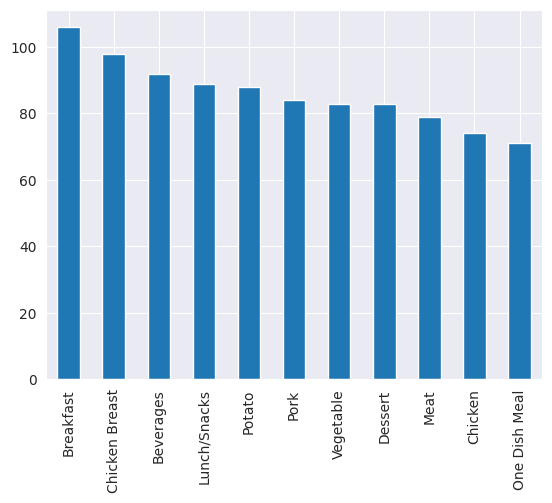

In [27]:
df.category.value_counts().plot(kind='bar')

In [28]:
df['high_traffic'] = df['high_traffic'] == "High"
df.high_traffic

0       True
1       True
2      False
3       True
4      False
       ...  
942    False
943     True
944     True
945     True
946    False
Name: high_traffic, Length: 947, dtype: bool

In [29]:
corrcoeff = df.drop("recipe", axis = 1).corr()
corrcoeff

/tmp/ipykernel_128951/3942402858.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrcoeff = df.drop("recipe", axis = 1).corr()


,calories,carbohydrate,sugar,protein,servings,high_traffic
calories,1.000000,-0.026212,-0.095351,0.175458,-0.033632,0.066316
carbohydrate,-0.026212,1.000000,0.078840,-0.043467,-0.021448,0.075117
sugar,-0.095351,0.078840,1.000000,-0.100593,-0.013034,-0.074293
protein,0.175458,-0.043467,-0.100593,1.000000,-0.013297,0.036912
servings,-0.033632,-0.021448,-0.013034,-0.013297,1.000000,0.048708
high_traffic,0.066316,0.075117,-0.074293,0.036912,0.048708,1.000000


<Axes: >

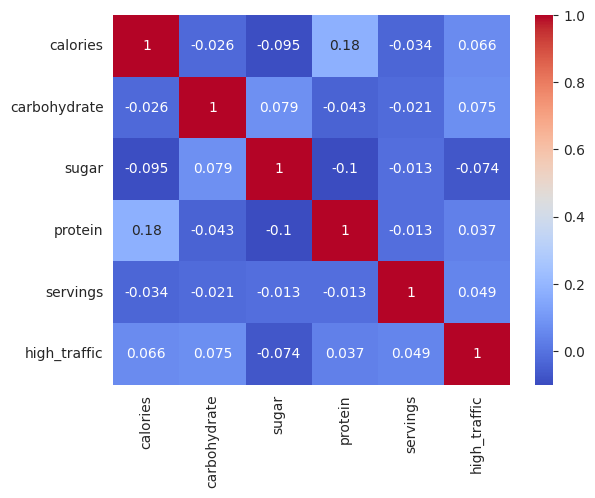

In [30]:
import seaborn as sns 

sns.heatmap(corrcoeff, annot=True, cmap='coolwarm')

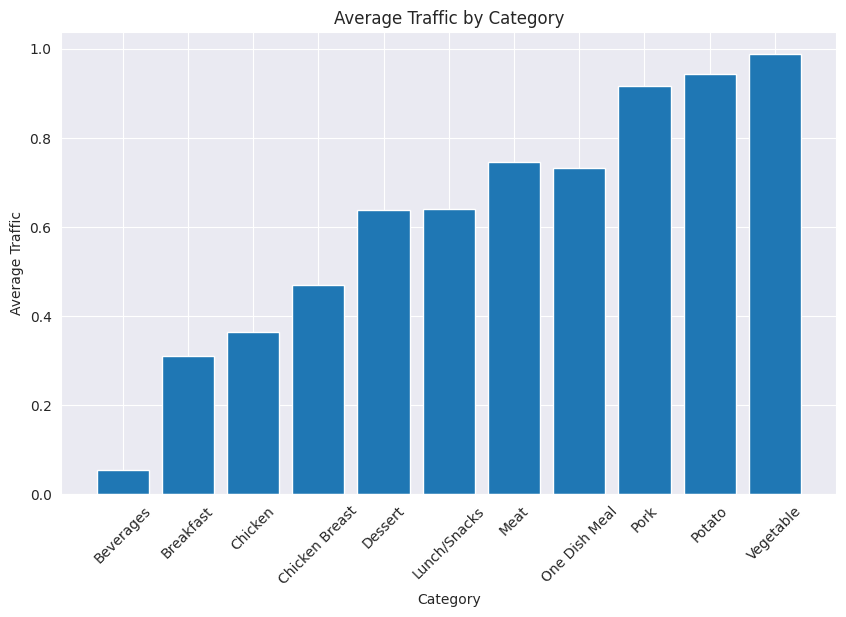

In [31]:

# Group by category and calculate the mean traffic
category_traffic = df.groupby('category')['high_traffic'].mean().reset_index()

# Plot the traffic based on category
plt.figure(figsize=(10, 6))
plt.bar(category_traffic['category'], category_traffic['high_traffic'])
plt.xlabel('Category')
plt.ylabel('Average Traffic')
plt.title('Average Traffic by Category')
plt.xticks(rotation=45)
plt.show()

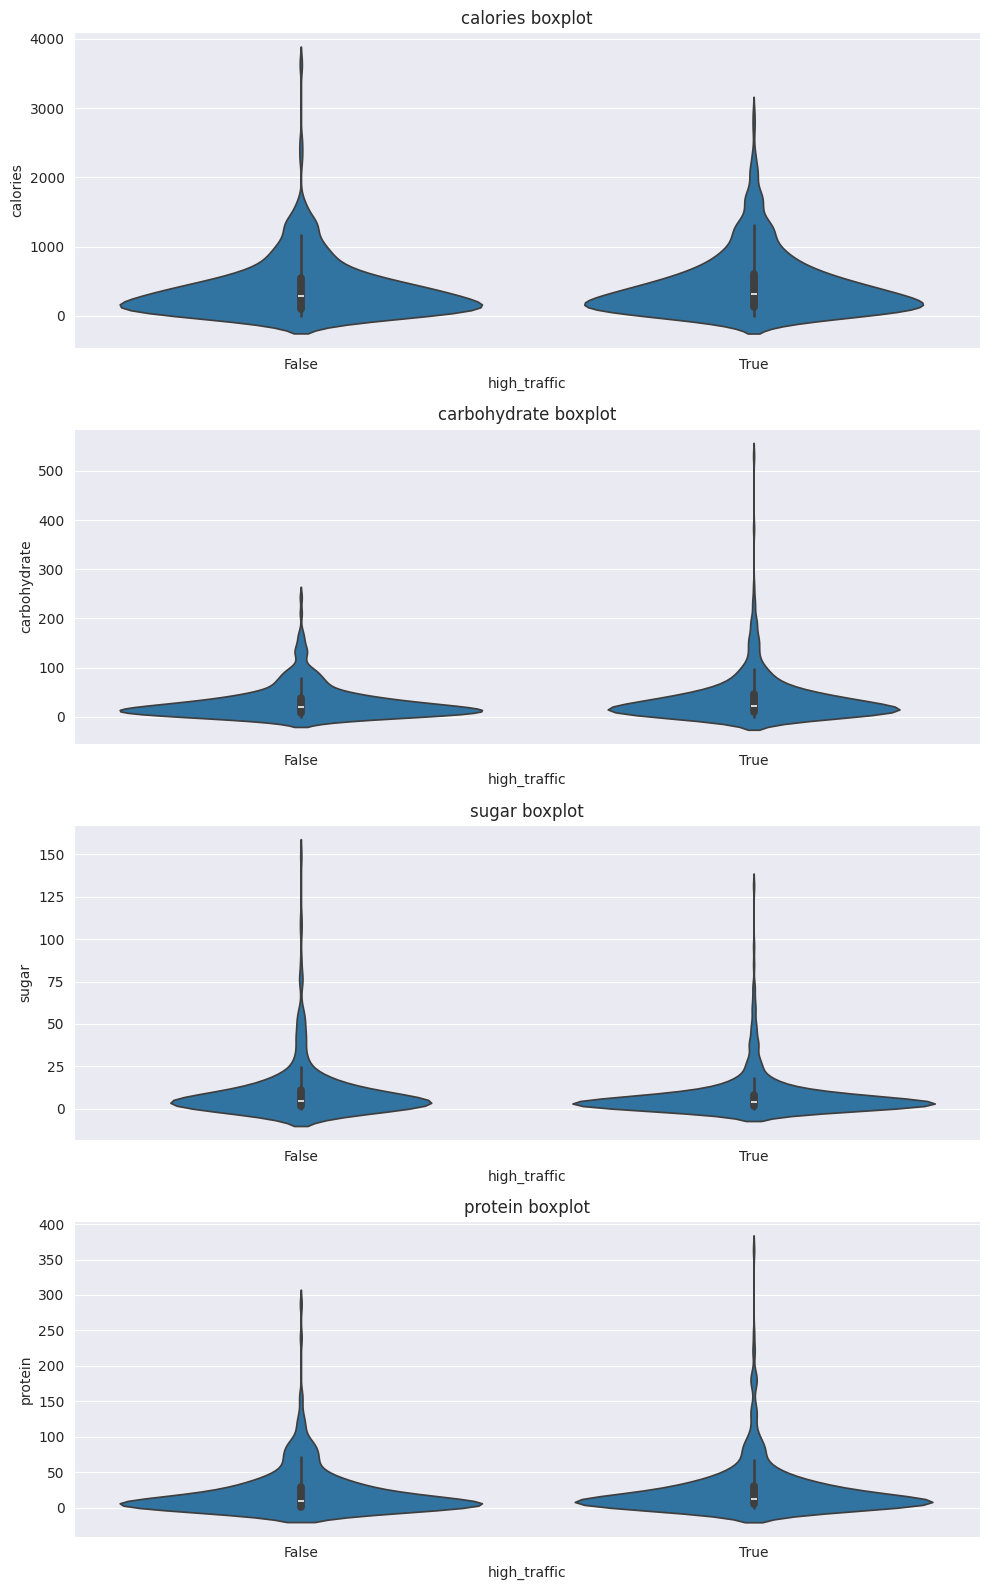

In [124]:
def plot_numeric_variables_boxplot(df, variables):
    fig, ax = plt.subplots(len(variables), 1, figsize=(10, 4 * len(variables)))
    for i, var in enumerate(variables):
        sns.violinplot(y=df[var], x = df["high_traffic"], ax=ax[i])
        ax[i].set_title(f'{var} boxplot')
    plt.tight_layout()
    plt.show()

plot_numeric_variables_boxplot(df, ['calories', 'carbohydrate', 'sugar', 'protein'])

In [32]:
category_traffic

,category,high_traffic
0,Beverages,0.054348
1,Breakfast,0.311321
2,Chicken,0.364865
3,Chicken Breast,0.469388
4,Dessert,0.638554
5,Lunch/Snacks,0.640449
6,Meat,0.746835
7,One Dish Meal,0.732394
8,Pork,0.916667
9,Potato,0.943182


![models](Models.png)

In [83]:
#baseline model

X_baseline = df.drop(['high_traffic','recipe', 'category'], axis=1)
y_baseline = df['high_traffic']

logreg_baseline = LogisticRegression()
logreg_baseline.fit(X_baseline, y_baseline)

y_pred_baseline = logreg_baseline.predict(X_baseline)

print(f'Baseline model accuracy: {accuracy_score(y_baseline, y_pred_baseline)}')

Baseline model accuracy: 0.6092925026399155


In [92]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# create feature matrix and target vector
X = df.drop(['high_traffic', 'recipe'], axis=1)
y = df['high_traffic']
# TODO: Use OneHotEncoder to encode categorical variables instead
# encode categorical variables
categorical_columns = ['category']
encoder = OneHotEncoder()
X_cat = pd.get_dummies(X[categorical_columns], drop_first=True)
X_cat

,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
942,0,0,0,0,1,0,0,0,0,0
943,0,0,0,0,0,0,0,0,1,0
944,0,0,0,0,0,0,0,1,0,0
945,0,0,0,0,0,0,0,0,1,0


In [103]:
# Assuming X and y are defined elsewhere
numerical_columns = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
scaler = StandardScaler()

# Copy and transform numerical data
X_numeric = X[numerical_columns].copy()
X_numeric = np.log1p(X_numeric)  # Apply log1p transformation
X_numeric = scaler.fit_transform(X_numeric)  # Standardize

# Convert the scaled NumPy array back to a DataFrame
X_numeric = pd.DataFrame(X_numeric, columns=numerical_columns)

# Assuming X_cat is already a DataFrame of categorical features
X_scaled = pd.concat([X_numeric, X_cat.reset_index(drop=True)], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Initialize and fit the logistic regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

 
# Make predictions on the test data
y_pred = logistic_regression.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Accuracy: 0.75, Precision: 0.76, Recall: 0.86, F1 Score: 0.81


In [104]:
roc_auc

0.7099811676082862

/tmp/ipykernel_128951/493049034.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=log_coef_sorted.index, x=log_coef_sorted['Coefficient'], orient='h', palette='coolwarm')


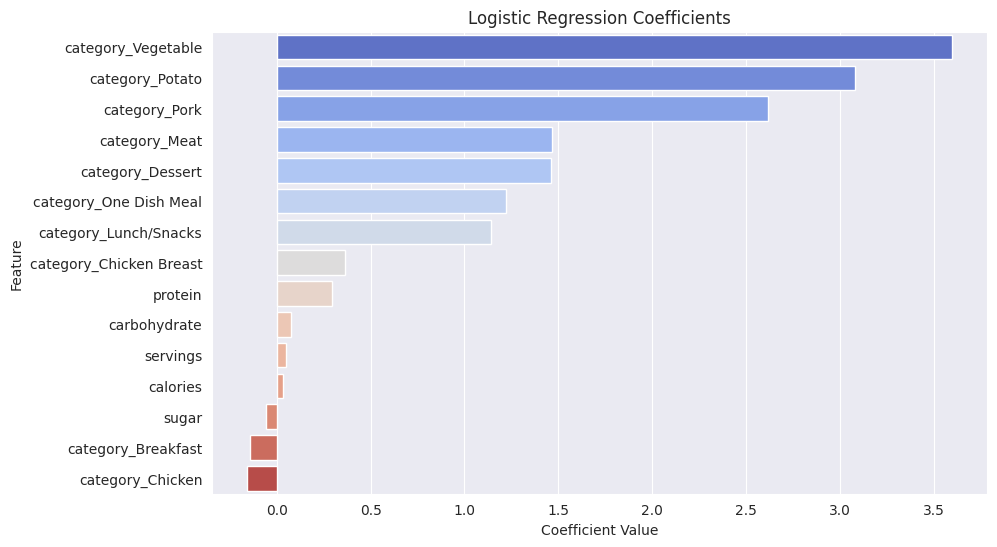

In [119]:

log_coef = pd.DataFrame(logistic_regression.coef_.flatten(), columns=['Coefficient'], index=X_scaled.columns)

# Sort coefficients from highest to lowest
log_coef_sorted = log_coef.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=log_coef_sorted.index, x=log_coef_sorted['Coefficient'], orient='h', palette='coolwarm')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [98]:
log_reg_cat = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.33, random_state=42)
log_reg_cat.fit(X_train, y_train)

y_pred = log_reg_cat.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.69      0.68       119
        True       0.81      0.79      0.80       194

    accuracy                           0.75       313
   macro avg       0.74      0.74      0.74       313
weighted avg       0.75      0.75      0.75       313



In [123]:
log_reg_cat_serve = LogisticRegression()
X_cat_serve = pd.concat([X_numeric[['servings']], X_cat], axis=1)
X_cat_serve
X_train, X_test, y_train, y_test = train_test_split(X_cat_serve, y, test_size=0.2, random_state=42)
log_reg_cat_serve.fit(X_train, y_train)

y_pred = log_reg_cat_serve.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.71      0.70      0.71        77
        True       0.80      0.81      0.80       113

    accuracy                           0.76       190
   macro avg       0.75      0.75      0.75       190
weighted avg       0.76      0.76      0.76       190



In [63]:
from sklearn.model_selection import GridSearchCV
model = LogisticRegression(max_iter=10000)
#use grid search to find the best hyperparameters for logistic regression
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=model, param_grid=params, cv = 5)

grid_search.fit(X_train, y_train)

hyparams = grid_search.best_params_
print(f'Best Hyperparameters: {hyparams}')

y_pred = grid_search.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Best Hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.76


/home/miniloda/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
105 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/miniloda/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/miniloda/.local/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/miniloda/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(sel

In [ ]:
a#!pip install xgboost

In [57]:
#use XGBoost as a comparison model
from xgboost import XGBClassifier

# define the model
xgboost_model = XGBClassifier()

# fit the model to the training data
xgboost_model.fit(X_train, y_train)

# make predictions on the test data
y_pred = xgboost_model.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Accuracy: 0.68, Precision: 0.73, Recall: 0.78, F1 Score: 0.75


In [58]:
from sklearn.model_selection import GridSearchCV
# define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
   'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 1],
}

# define the grid search model
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_
best_params


Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}

In [59]:
y_pred = grid_search.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

Accuracy: 0.71, Precision: 0.72, Recall: 0.86, F1 Score: 0.78


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
# define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(kernel='linear'),
}

# evaluate the classifiers
results = {}
for name, classifier in classifiers.items():
    scores = cross_val_score(classifier, X_test, y_test, cv=5)
    results[name] = scores.mean()

results


{'Logistic Regression': 0.6526315789473685,
 'XGBoost': 0.5157894736842106,
 'Random Forest': 0.5894736842105263,
 'K-Nearest Neighbors': 0.5789473684210525,
 'Support Vector Machine': 0.631578947368421}

In [70]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print(f'K-Nearest Neighbors Accuracy: {knn_accuracy:.2f}')

K-Nearest Neighbors Accuracy: 0.63


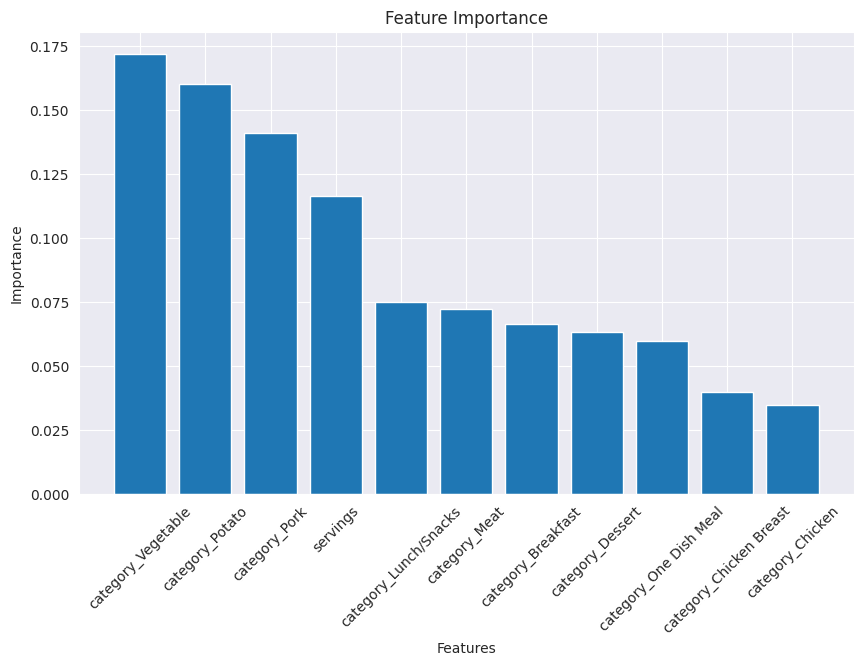

In [125]:
# Train a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train and y_train are already defined
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Extract feature importances
importances = rf.feature_importances_
features = X_train.columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.62      0.67        77
        True       0.77      0.84      0.80       113

    accuracy                           0.75       190
   macro avg       0.75      0.73      0.74       190
weighted avg       0.75      0.75      0.75       190



## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation